In [15]:
#хорди крила
H1 = 300
H2 = 200
V = 25

R1 = 68 * H1 * V
R2 = 68 * H2 * V

#хорди хвоста
h1 = 300
h2 = 150
V = 25

r1 = 68 * h1 * V
r2 = 68 * h2 * V

R1



510000

In [16]:
R2

340000

In [17]:
r1

510000

In [18]:
r2

255000

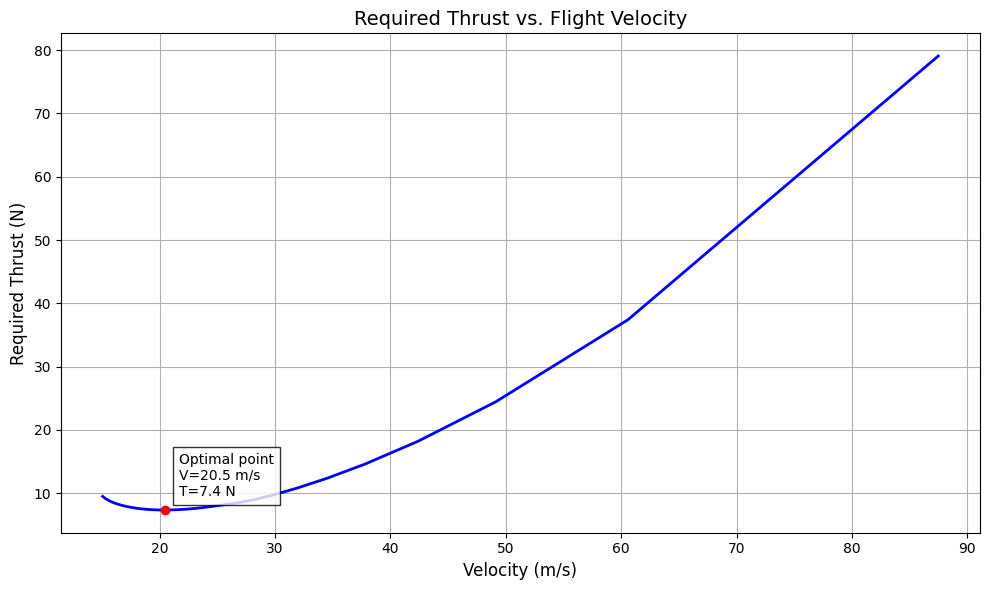

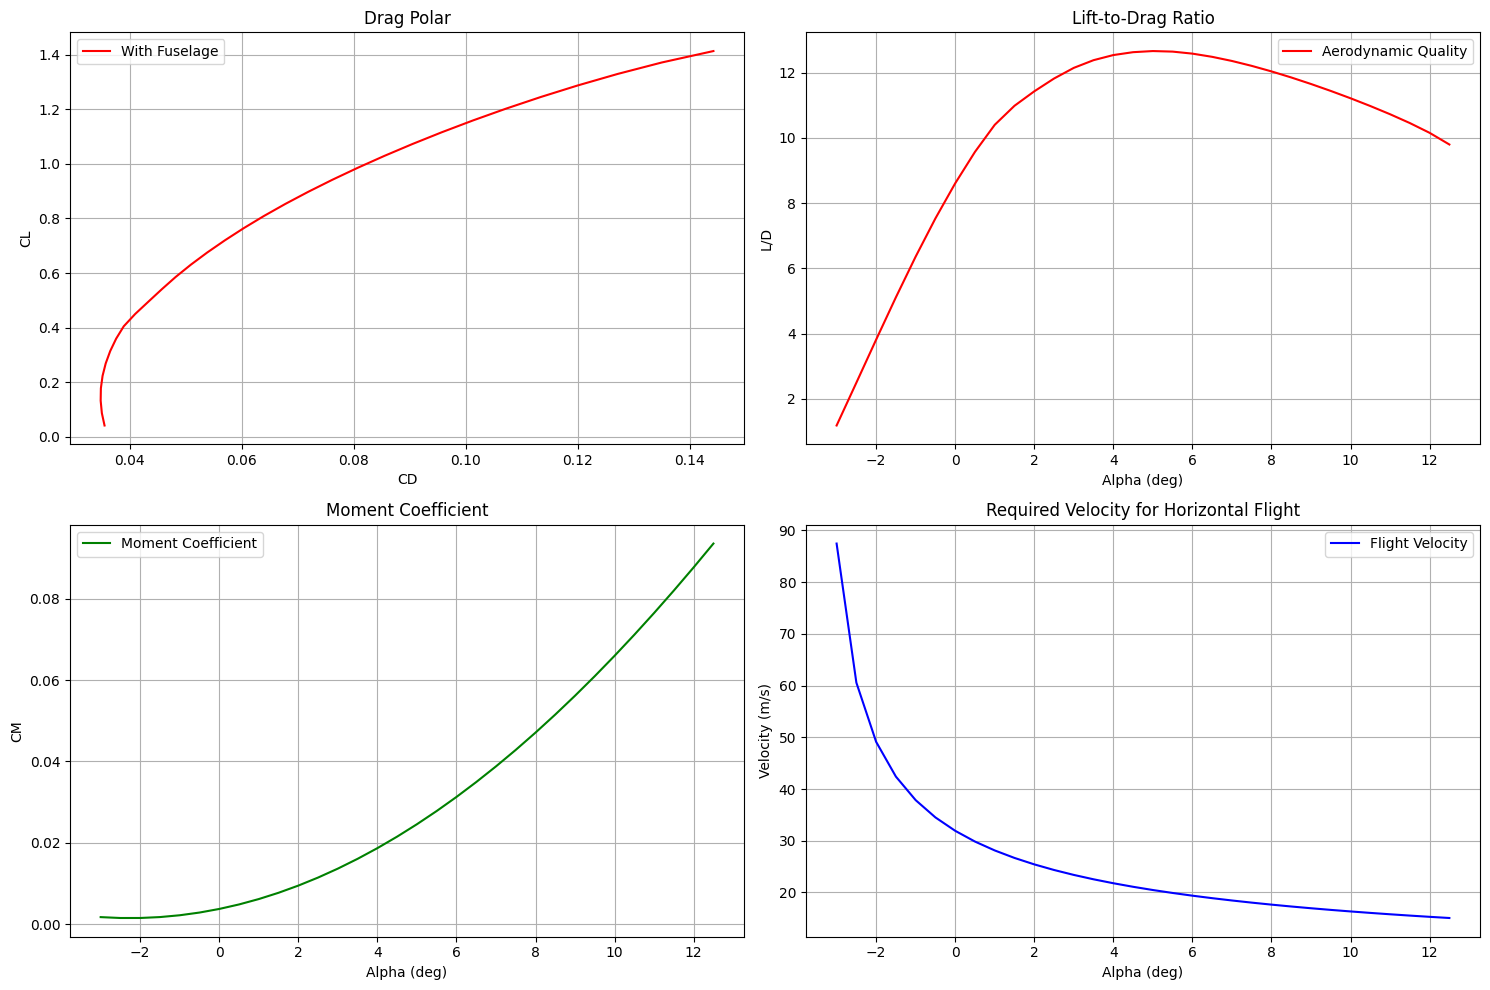


Aircraft Analysis Results:
Aircraft mass: 9.5 kg
Wing area: 0.475 m²
Maximum L/D: 12.66

Neutral Point Position: 0.244c
dCm/dα: 0.0060 1/deg

Optimal Flight Conditions:
Minimum thrust: 7.4 N
Optimal velocity: 20.5 m/s
Optimal angle of attack: 5.0°


In [31]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_wing_area(c1, c2, semi_span):
    """
    Calculate wing area for trapezoidal wing

    Parameters:
    c1 (float): Root chord in meters
    c2 (float): Tip chord in meters
    semi_span (float): Semi-span in meters
    """
    single_wing_area = (c1 + c2) / 2 * semi_span  # Area of one wing
    total_area = 2 * single_wing_area  # Area of both wings

    return total_area



def analyze_file(filename, delta_cx0=0.02, mass=9.5):
    # Constants
    c1 = 0.3  # root chord
    c2 = 0.2  # tip chord
    rho = 1.225
    g = 9.81
    semi_span = 0.95
    # semi-span
      # Calculate wing area
    S = calculate_wing_area(c1, c2, semi_span)

    # Read data from file
    data = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines[8:]:
            if line.strip():
                values = line.split()
                if len(values) >= 6:
                    alpha = float(values[0])
                    CL = float(values[2])
                    CD = float(values[5])
                    CM = float(values[3])
                    data.append([alpha, CL, CD, CM])

    # Convert to numpy arrays
    data = np.array(data)
    alpha = data[:, 0]
    CL = data[:, 1]
    CD = data[:, 2]
    CM = data[:, 3]

    # Add fuselage drag
    CD_total = CD + delta_cx0

    # Calculate L/D ratio
    efficiency = CL / CD_total

    # Calculate velocities
    CL_safe = np.where(CL < 0.001, 0.001, CL)
    velocities = np.sqrt((2 * mass * g) / (rho * S * CL_safe))

    # Calculate thrust
    thrust = 0.5 * rho * velocities**2 * S * CD_total

    # Filter out unrealistic values
    mask = (velocities < 100) & (velocities > 5)

    # Apply mask to all arrays
    alpha = alpha[mask]
    CL = CL[mask]
    CD_total = CD_total[mask]
    CM = CM[mask]
    efficiency = efficiency[mask]
    velocities = velocities[mask]
    thrust = thrust[mask]

    # Calculate neutral point
    cm_alpha = np.gradient(CM, alpha)
    cm_alpha_avg = np.mean(cm_alpha[len(cm_alpha)//4:3*len(cm_alpha)//4])
    neutral_point = 0.25 - cm_alpha_avg

    # Thrust vs velocity plot
    plt.figure(figsize=(10, 6))
    plt.plot(velocities, thrust, 'b-', linewidth=2)
    plt.xlabel('Velocity (m/s)', fontsize=12)
    plt.ylabel('Required Thrust (N)', fontsize=12)
    plt.title('Required Thrust vs. Flight Velocity', fontsize=14)
    plt.grid(True)

    # Add optimal point
    idx_opt = np.argmin(thrust)
    plt.plot(velocities[idx_opt], thrust[idx_opt], 'ro')
    plt.annotate(f'Optimal point\nV={velocities[idx_opt]:.1f} m/s\nT={thrust[idx_opt]:.1f} N',
                xy=(velocities[idx_opt], thrust[idx_opt]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

    # Analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(CD_total, CL, 'r-', label='With Fuselage')
    ax1.set_xlabel('CD')
    ax1.set_ylabel('CL')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Drag Polar')

    ax2.plot(alpha, efficiency, 'r-', label='Aerodynamic Quality')
    ax2.set_xlabel('Alpha (deg)')
    ax2.set_ylabel('L/D')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Lift-to-Drag Ratio')

    ax3.plot(alpha, CM, 'g-', label='Moment Coefficient')
    ax3.set_xlabel('Alpha (deg)')
    ax3.set_ylabel('CM')
    ax3.grid(True)
    ax3.legend()
    ax3.set_title('Moment Coefficient')

    ax4.plot(alpha, velocities, 'b-', label='Flight Velocity')
    ax4.set_xlabel('Alpha (deg)')
    ax4.set_ylabel('Velocity (m/s)')
    ax4.grid(True)
    ax4.legend()
    ax4.set_title('Required Velocity for Horizontal Flight')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nAircraft Analysis Results:")
    print(f"Aircraft mass: {mass} kg")
    print(f"Wing area: {S} m²")
    print(f"Maximum L/D: {np.max(efficiency):.2f}")
    print(f"\nNeutral Point Position: {neutral_point:.3f}c")
    print(f"dCm/dα: {cm_alpha_avg:.4f} 1/deg")
    print("\nOptimal Flight Conditions:")
    print(f"Minimum thrust: {np.min(thrust):.1f} N")
    print(f"Optimal velocity: {velocities[idx_opt]:.1f} m/s")
    print(f"Optimal angle of attack: {alpha[idx_opt]:.1f}°")

    # Save data
    results = np.column_stack((alpha, CL, CD_total, CM, efficiency, velocities, thrust))
    header = 'alpha,CL,CD,CM,L/D,velocity,thrust'
    np.savetxt('flight_analysis.csv', results, delimiter=',', header=header, comments='')

    return {
        'neutral_point': neutral_point,
        'optimal_velocity': velocities[idx_opt],
        'optimal_thrust': thrust[idx_opt],
        'data': {
            'alpha': alpha,
            'velocities': velocities,
            'thrust': thrust,
            'efficiency': efficiency,
            'cm': CM
        }
    }

# Example usage
if __name__ == "__main__":
    results = analyze_file('polar.txt', delta_cx0=0.02, mass=9.5)
